In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,  classification_report
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import ipaddress

import warnings
warnings.simplefilter('ignore')

In [2]:
#DATADIR = '/home/infres/abiapo/prim/data'
DATADIR = '/home/infres/sagbo-21/Documents/PRIM/PRIM/data'

In [3]:
data = pd.read_csv(DATADIR+'/unbalance_mix_data_40_60.csv')
data.head()

,Unnamed:_0,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,...,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,SimillarHTTP,Inbound,Label,label
0,63090,172.16.0.5-192.168.50.1-53886-52313-17,172.16.0.5,53886,192.168.50.1,52313,17,2018-12-01 12:55:39.691985,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP,1
1,331646,172.16.0.5-192.168.50.4-8761-40089-6,172.16.0.5,8761,192.168.50.4,40089,6,2018-11-03 11:29:59.315895,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn,1
2,23868,172.16.0.5-192.168.50.1-62707-26320-17,172.16.0.5,62707,192.168.50.1,26320,17,2018-12-01 13:53:58.779233,6004043,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
3,47275,172.16.0.5-192.168.50.1-62519-8952-17,172.16.0.5,62519,192.168.50.1,8952,17,2018-12-01 13:56:35.445012,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
4,115481,172.16.0.5-192.168.50.1-62543-55990-17,172.16.0.5,62543,192.168.50.1,55990,17,2018-12-01 13:45:14.614697,3001833,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1


In [4]:
data = data.drop(['Unnamed:_0'],axis=1)

In [5]:
data['Source_IP'] = data['Source_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data['Destination_IP'] = data['Destination_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))

In [6]:
data = data.drop(['Flow_ID'],axis=1)

In [7]:
data = data.drop(['Timestamp'],axis=1)

SimilarHTTP has a different structure. Maybe we could perform a wordembedding to transform the string to numerical value. For the moment we will delete this feature.

In [8]:
data = data.drop(['SimillarHTTP'],axis=1)

In [9]:
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [10]:
X = data.iloc[:,:-2]
y = data.iloc[:,-1].to_numpy()

In [11]:
all(X>0)

True

In [12]:
X.iloc[:,[35,36,37,47,50,54,60,61,62,63,64,65]]

,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,FIN_Flag_Count,PSH_Flag_Count,ECE_Flag_Count,Fwd_Avg_Bytes_Bulk,Fwd_Avg_Packets_Bulk,Fwd_Avg_Bulk_Rate,Bwd_Avg_Bytes_Bulk,Bwd_Avg_Packets_Bulk,Bwd_Avg_Bulk_Rate
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
273172,0,0,0,0,0,0,0,0,0,0,0,0
273173,0,0,0,0,0,0,0,0,0,0,0,0
273174,0,0,0,0,0,0,0,0,0,0,0,0
273175,0,0,0,0,0,0,0,0,0,0,0,0


# Feature selection : Filter Methods

**Definition**
Filter methods select features from a dataset independently for any machine learning algorithm. 
These methods rely only on the characteristics of these variables, so features are filtered out of the data before learning begins.
These methods are powerful and simple and help to quickly remove features— and they are generally the first step in any feature selection pipeline

**Avantages**
- Selected features can be used in any machine learning algorithm,
- They’re computationally inexpensive—you can process thousands of features in a matter of seconds.

Filter methods are very good for eliminating irrelevant, redundant, constant, duplicated, and correlated features.

## Statistical & Ranking Filter Methods

These methods are statistical tests that evaluate each feature individually. By shedding light on the target, they evaluate whether the variable is important in order to discriminate against the target.
Essentially, these methods rank the features based on certain criteria or metrics and then select the features with the highest ranking.

### ANOVA Univariate Test

A univariate test, or more specifically ANOVA ( — short for ANalysis Of VAriance), is similar to the previous scores, as it measures the dependence of two variables.
ANOVA assumes a linear relationship between the variables and the target, and also that the variables are normally distributed.

In [13]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SelectFromModel

In [14]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 20).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [15]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.head()

,Specs,Score
0,Source_IP,4633.602230
1,Source_Port,17258.395965
2,Destination_IP,197819.957676
3,Destination_Port,84977.998170
4,Protocol,154364.658843


In [16]:
print(featureScores.nlargest(20,'Score'))

                     Specs          Score
82                 Inbound  693096.980620
2           Destination_IP  197819.957676
42       Min_Packet_Length  177457.468756
11   Fwd_Packet_Length_Min  175688.896293
12  Fwd_Packet_Length_Mean  159589.647486
57    Avg_Fwd_Segment_Size  159589.647486
4                 Protocol  154364.658843
44      Packet_Length_Mean  135164.302717
56     Average_Packet_Size  134369.075741
52          URG_Flag_Count  133208.737586
55           Down_Up_Ratio  120599.633636
40           Fwd_Packets_s   88941.867795
19          Flow_Packets_s   87574.227354
3         Destination_Port   84977.998170
18            Flow_Bytes_s   76196.274217
10   Fwd_Packet_Length_Max   68083.407677
15   Bwd_Packet_Length_Min   51885.654547
53          CWE_Flag_Count   41621.910073
16  Bwd_Packet_Length_Mean   29426.192806
58    Avg_Bwd_Segment_Size   29426.192806


<AxesSubplot:xlabel='Score', ylabel='Specs'>

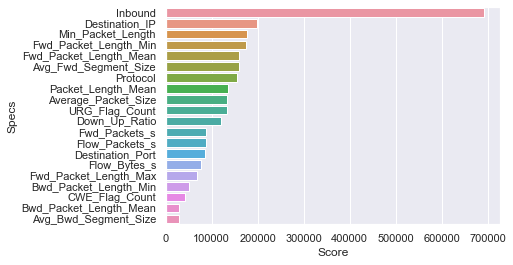

In [17]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(data = featureScores.nlargest(20,'Score'), x = "Score", y = "Specs")

### Mutual Information
Mutual information a measure of the mutual dependence of two variables. It measures the amount of information obtained about one variable through observing the other variable. In other words, it determines how much we can know about one variable by understanding another—it’s a little bit like correlation, but mutual information is more general.


In [18]:
#Select top 2 features based on mutual_info_classif
selector = SelectKBest(mutual_info_classif, k = 20).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [19]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.head()

,Specs,Score
0,Source_IP,0.698843
1,Source_Port,0.417641
2,Destination_IP,0.684193
3,Destination_Port,0.532676
4,Protocol,0.228999


In [20]:
print(featureScores.nlargest(20,'Score'))

                          Specs     Score
0                     Source_IP  0.698843
2                Destination_IP  0.684193
56          Average_Packet_Size  0.577990
44           Packet_Length_Mean  0.561816
12       Fwd_Packet_Length_Mean  0.561487
57         Avg_Fwd_Segment_Size  0.561368
42            Min_Packet_Length  0.556826
11        Fwd_Packet_Length_Min  0.555219
43            Max_Packet_Length  0.544278
18                 Flow_Bytes_s  0.540018
8   Total_Length_of_Fwd_Packets  0.539748
67            Subflow_Fwd_Bytes  0.539534
3              Destination_Port  0.532676
10        Fwd_Packet_Length_Max  0.526146
19               Flow_Packets_s  0.462042
82                      Inbound  0.459782
40                Fwd_Packets_s  0.457617
22                 Flow_IAT_Max  0.448004
20                Flow_IAT_Mean  0.443931
5                 Flow_Duration  0.436883


<AxesSubplot:xlabel='Score', ylabel='Specs'>

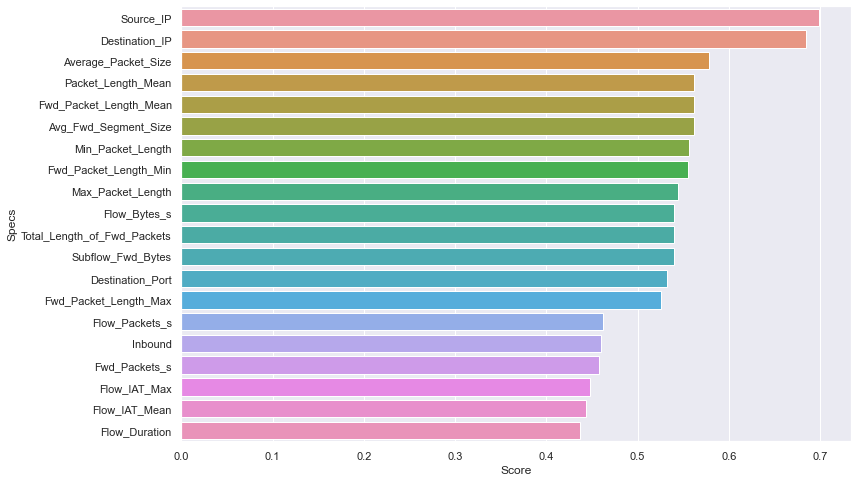

In [21]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(data = featureScores.nlargest(20,'Score'), x = "Score", y = "Specs")

To choose a value of $k$ we must compare the performance of the model with classification report of serveral techniques. Now we focus on the different selection techniques

## Feature Correlation Method

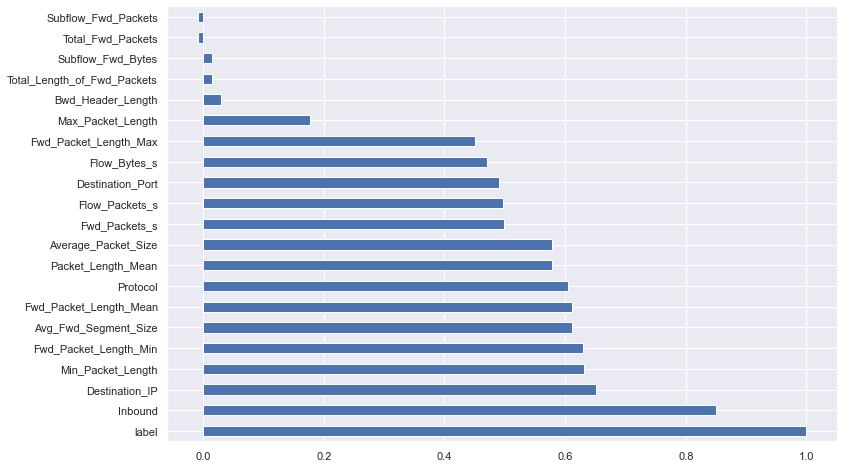

In [22]:
# determine 20 most correlated features
plt.figure(figsize=(12,8))
data_corr_label = data.corr()['label'].sort_values(ascending=False).head(21)
top_corr_features = data_corr_label.index
# plot top 20 most correlated features to our target (HEALTH)
data_corr_label.plot(kind='barh')
plt.show()

In [23]:
print(data_corr_label)

label                          1.000000
Inbound                        0.849254
Destination_IP                 0.651743
Min_Packet_Length              0.631243
Fwd_Packet_Length_Min          0.629341
Avg_Fwd_Segment_Size           0.611003
Fwd_Packet_Length_Mean         0.611003
Protocol                       0.604624
Packet_Length_Mean             0.579093
Average_Packet_Size            0.577957
Fwd_Packets_s                  0.499252
Flow_Packets_s                 0.496351
Destination_Port               0.490734
Flow_Bytes_s                   0.470578
Fwd_Packet_Length_Max          0.450160
Max_Packet_Length              0.176436
Bwd_Header_Length              0.030292
Total_Length_of_Fwd_Packets    0.014103
Subflow_Fwd_Bytes              0.014103
Total_Fwd_Packets             -0.008739
Subflow_Fwd_Packets           -0.008739
Name: label, dtype: float64


# Embedded Method

**Definition**
Embedded methods complete the feature selection process within the construction of the machine learning algorithm itself. In other words, they perform feature selection during the model training, which is why we call them embedded methods.

A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification/regression at the same time.

**Advantages**
The embedded method solves both issues we encountered with the filter and wrapper methods by combining their advantages. Here’s how:
- They take into consideration the interaction of features like wrapper methods do.
- They are faster like filter methods.
- They are more accurate than filter methods.
- They find the feature subset for the algorithm being trained.
- They are much less prone to overfitting.

### Tree-based feature importance

Tree-based algorithms and models (i.e. random forest) are well-established algorithms that not only offer good predictive performance but can also provide us with what we call feature importance as a way to select features.

**Feature importance**

Feature importance tells us which variables are more important in making accurate predictions on the target variable/class. In other words, it identifies which features are the most used by the machine learning algorithm in order to predict the target.

#### Extra Tree Classifier 

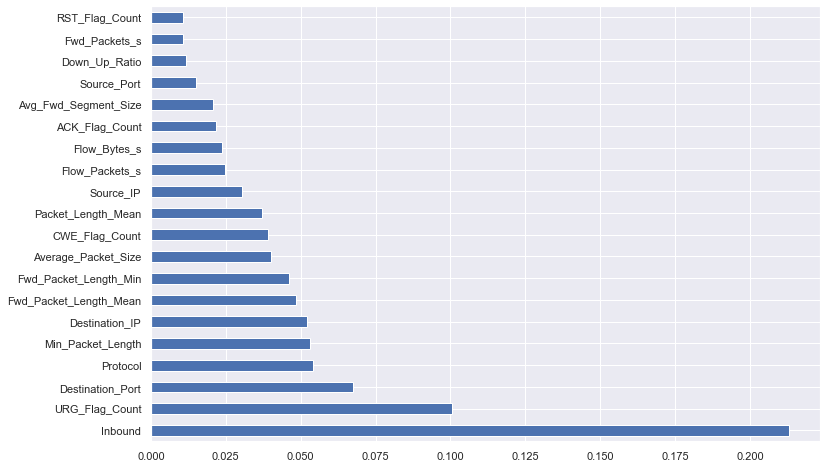

In [24]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

#### RandomForest Classifier

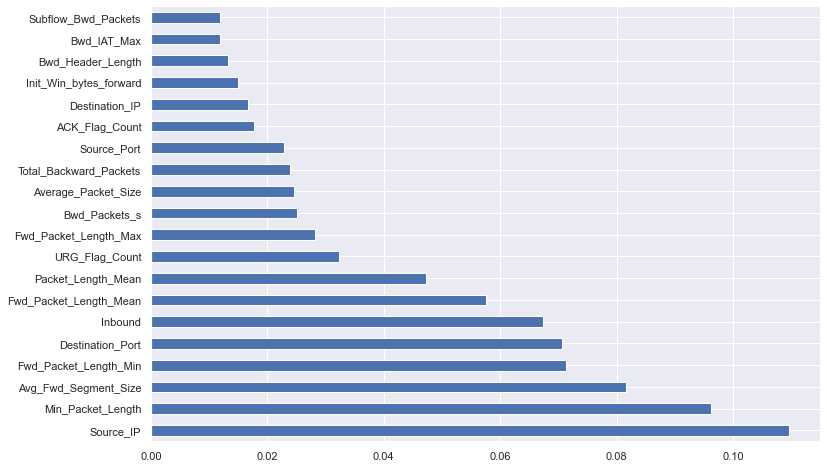

In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Feature Selection via SelectFromModel

In [26]:
from sklearn.linear_model import Lasso, LogisticRegression

In [27]:
sfm_selector = SelectFromModel(estimator = RandomForestClassifier())
sfm_selector.fit(X, y)
X.columns[sfm_selector.get_support()]

Index(['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port',
       'Protocol', 'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets',
       'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min',
       'Fwd_Packet_Length_Mean', 'Bwd_IAT_Total', 'Bwd_IAT_Min',
       'Bwd_Header_Length', 'Min_Packet_Length', 'Packet_Length_Mean',
       'ACK_Flag_Count', 'URG_Flag_Count', 'Average_Packet_Size',
       'Avg_Fwd_Segment_Size', 'Subflow_Fwd_Bytes', 'Subflow_Bwd_Packets',
       'Init_Win_bytes_forward', 'Inbound'],
      dtype='object')

In [28]:
sfm_selector = SelectFromModel(estimator = LogisticRegression(C=1, penalty='l2'))
sfm_selector.fit(X, y)
X.columns[sfm_selector.get_support()]

Index(['Flow_Duration', 'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Std',
       'Flow_IAT_Max', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Bwd_IAT_Total', 'Bwd_IAT_Max', 'Bwd_Header_Length', 'Fwd_Packets_s',
       'min_seg_size_forward', 'Active_Mean', 'Active_Max', 'Active_Min',
       'Idle_Mean', 'Idle_Max', 'Idle_Min'],
      dtype='object')

# Wrapper Methods

**Definition**

Wrapper methods work by evaluating a subset of features using a machine learning algorithm that employs a search strategy to look through the space of possible feature subsets, evaluating each subset based on the quality of the performance of a given algorithm.

These methods are called greedy algorithms because they aim to find the best possible combination of features that result in the best performant model— which will be computationally expensive, and often impractical in the case of exhaustive search.

Practically any combination of a search strategy and a machine learning algorithm can be used as a wrapper.

**Advantages**

Given the issues we encountered using filter methods, wrapper methods present two main advantages that deal with those issues:

- They detect the interaction between variables
- They find the optimal feature subset for the desired machine learning algorithm

The wrapper methods usually result in better predictive accuracy than filter methods.

## Recursive Feature Elimination

In [29]:
rfe_selector = RFE(estimator=RandomForestClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X,y)

RFE(estimator=RandomForestClassifier(), n_features_to_select=20)

In [30]:
print(X.loc[:,rfe_selector.support_].columns.to_numpy())

['Source_IP' 'Source_Port' 'Destination_IP' 'Destination_Port' 'Protocol'
 'Total_Fwd_Packets' 'Fwd_Packet_Length_Min' 'Fwd_Packet_Length_Mean'
 'Fwd_Packets_s' 'Min_Packet_Length' 'Packet_Length_Mean'
 'Packet_Length_Std' 'ACK_Flag_Count' 'URG_Flag_Count' 'CWE_Flag_Count'
 'Average_Packet_Size' 'Avg_Fwd_Segment_Size' 'Subflow_Fwd_Bytes'
 'Init_Win_bytes_forward' 'Inbound']


## Sequential Feature Selection (SFS)

Source: https://heartbeat.comet.ml/hands-on-with-feature-selection-techniques-an-introduction-1d8dc6d86c16 

# Hybrid methods

## Filter + Embedded

In [31]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [32]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

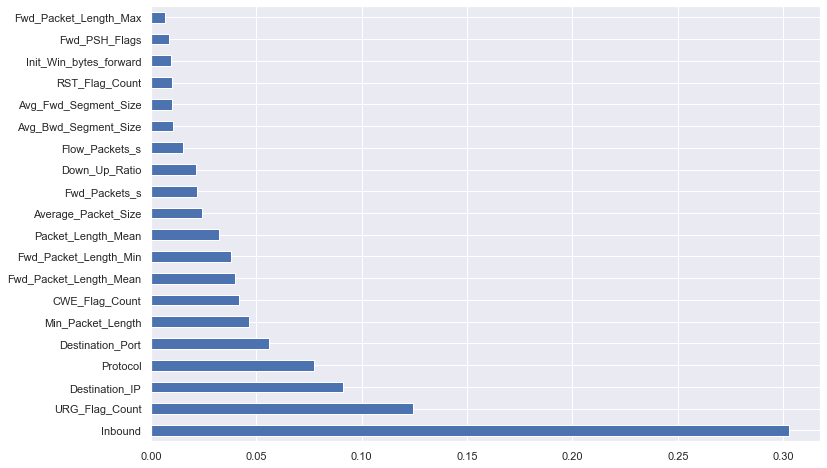

In [33]:
plt.figure(figsize=(12,8))
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X[preselect_feature],y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X[preselect_feature].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [34]:
print(feat_importances.nlargest(20).index.to_list())

['Inbound', 'URG_Flag_Count', 'Destination_IP', 'Protocol', 'Destination_Port', 'Min_Packet_Length', 'CWE_Flag_Count', 'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Min', 'Packet_Length_Mean', 'Average_Packet_Size', 'Fwd_Packets_s', 'Down_Up_Ratio', 'Flow_Packets_s', 'Avg_Bwd_Segment_Size', 'Avg_Fwd_Segment_Size', 'RST_Flag_Count', 'Init_Win_bytes_forward', 'Fwd_PSH_Flags', 'Fwd_Packet_Length_Max']


In [35]:
#Select top 2 features based on mutual_info
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

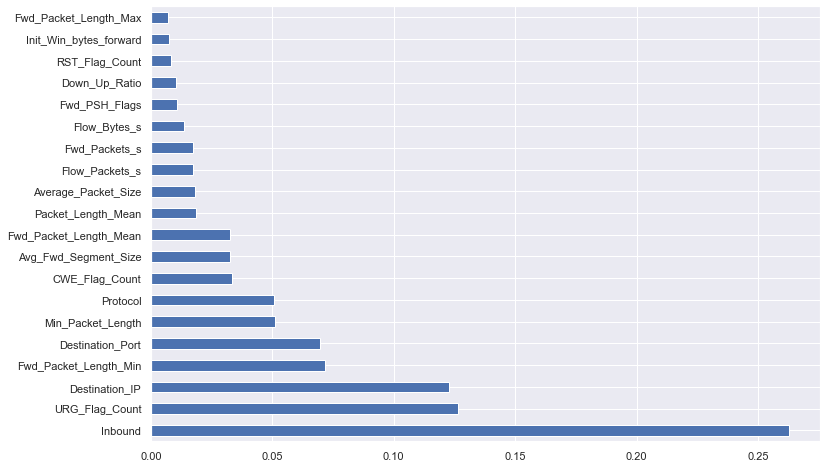

In [36]:
plt.figure(figsize=(12,8))
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X[preselect_feature],y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X[preselect_feature].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [37]:
print(feat_importances.nlargest(20).index.to_list())

['Inbound', 'URG_Flag_Count', 'Destination_IP', 'Fwd_Packet_Length_Min', 'Destination_Port', 'Min_Packet_Length', 'Protocol', 'CWE_Flag_Count', 'Avg_Fwd_Segment_Size', 'Fwd_Packet_Length_Mean', 'Packet_Length_Mean', 'Average_Packet_Size', 'Flow_Packets_s', 'Fwd_Packets_s', 'Flow_Bytes_s', 'Fwd_PSH_Flags', 'Down_Up_Ratio', 'RST_Flag_Count', 'Init_Win_bytes_forward', 'Fwd_Packet_Length_Max']


## Filter + Wrapper 

In [38]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

In [39]:
rfe_selector = RFE(estimator=RandomForestClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X[preselect_feature],y)
print(X[preselect_feature].loc[:,rfe_selector.support_].columns.to_list())

['Inbound', 'Destination_IP', 'Min_Packet_Length', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 'Avg_Fwd_Segment_Size', 'Protocol', 'Packet_Length_Mean', 'Average_Packet_Size', 'URG_Flag_Count', 'Down_Up_Ratio', 'Fwd_Packets_s', 'Flow_Packets_s', 'Destination_Port', 'Flow_Bytes_s', 'Fwd_Packet_Length_Max', 'CWE_Flag_Count', 'Avg_Bwd_Segment_Size', 'Init_Win_bytes_forward', 'Packet_Length_Std']


In [40]:
#Select top 2 features based on mutual_info
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

In [41]:
rfe_selector = RFE(estimator=RandomForestClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X[preselect_feature],y)
print(X[preselect_feature].loc[:,rfe_selector.support_].columns.to_list())

['Inbound', 'Destination_IP', 'Min_Packet_Length', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 'Avg_Fwd_Segment_Size', 'Protocol', 'Packet_Length_Mean', 'Average_Packet_Size', 'URG_Flag_Count', 'Down_Up_Ratio', 'Fwd_Packets_s', 'Flow_Packets_s', 'Destination_Port', 'Flow_Bytes_s', 'Fwd_Packet_Length_Max', 'CWE_Flag_Count', 'Avg_Bwd_Segment_Size', 'Init_Win_bytes_forward', 'Packet_Length_Std']


## Embedded + Wrapper

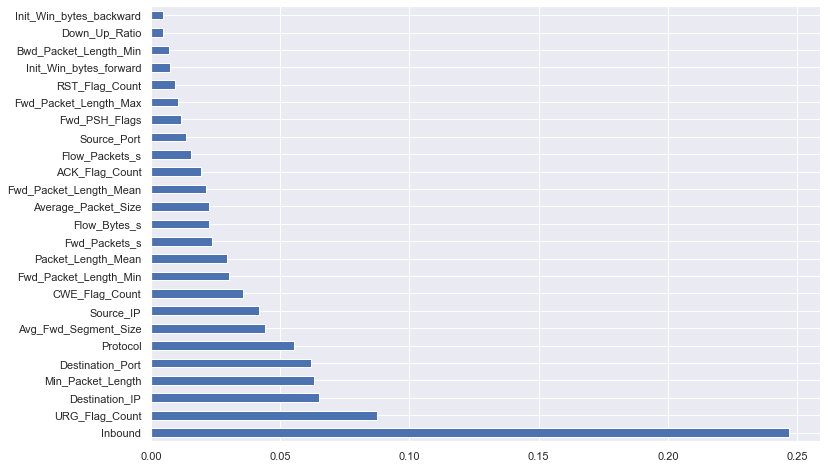

In [42]:
plt.figure(figsize=(12,8))
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [43]:
feature_preselect = feat_importances.nlargest(25).index.to_list()

In [44]:
from sklearn.tree import DecisionTreeClassifier
rfe_selector = RFE(estimator=DecisionTreeClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X[feature_preselect],y)
print(X[feature_preselect].loc[:,rfe_selector.support_].columns.to_list())

['Destination_IP', 'Min_Packet_Length', 'Destination_Port', 'Protocol', 'Avg_Fwd_Segment_Size', 'Source_IP', 'CWE_Flag_Count', 'Fwd_Packet_Length_Min', 'Packet_Length_Mean', 'Fwd_Packets_s', 'Average_Packet_Size', 'Fwd_Packet_Length_Mean', 'ACK_Flag_Count', 'Flow_Packets_s', 'Source_Port', 'Fwd_PSH_Flags', 'Fwd_Packet_Length_Max', 'RST_Flag_Count', 'Init_Win_bytes_forward', 'Bwd_Packet_Length_Min']


# SHAP

In [45]:
import shap
import xgboost as xgb
import lightgbm

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)   

In [47]:
xgb_model = xgb.train({'objective':'binary:logitraw'}, xgb.DMatrix(X_train, label=y_train))
#xgb_model = xgb.train({'objective':'binary:logistic'}, xgb.DMatrix(X_train, label=y_train))

[08:01:48] WARNING: ../src/learner.cc:1205: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [49]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

In [50]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()

In [51]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

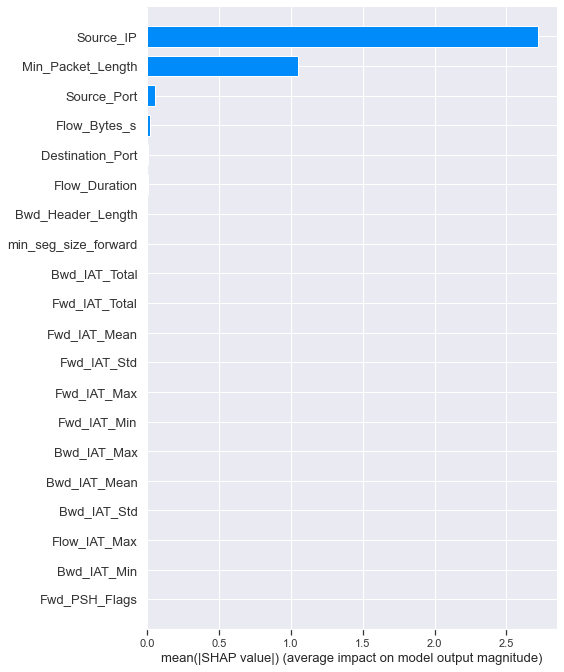

In [52]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

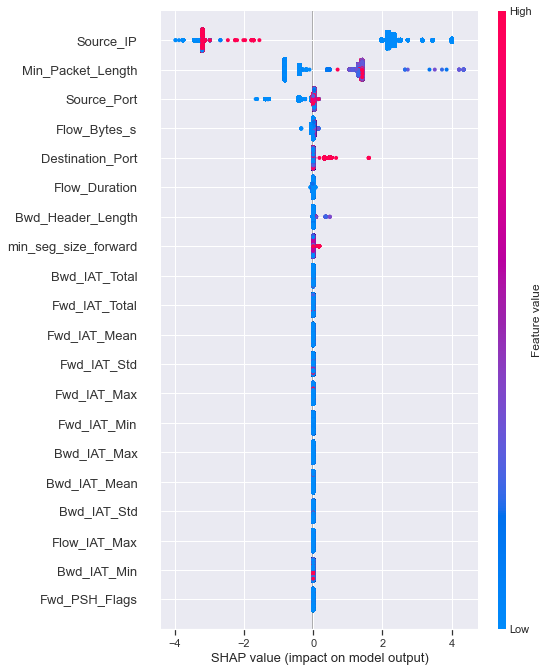

In [53]:
shap.summary_plot(shap_values_XGB_train, X_train)